In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np
from networks.net_utils import elu, sigmoid, tanh

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.L1_REG = 0
config.IS_CONVOLUTIONAL = False
config.SAVE_PATH = './models/permuted_minst/kaf_trainable_dict_comparison'
config.MODEL_NAME = 'ewc'
print(config)

confing_kaf = copy.copy(config)
confing_kaf.MODEL_NAME = 'no_init'
confing_kaf.EWC_IMPORTANCE = 100

confing_kaf_tanh = copy.copy(config)
confing_kaf_tanh.MODEL_NAME = 'tanh_init'
confing_kaf_tanh.EWC_IMPORTANCE = 100

confing_kaf_sigmoid = copy.copy(config)
confing_kaf_sigmoid.MODEL_NAME = 'sigmoid_init'
confing_kaf_sigmoid.EWC_IMPORTANCE = 100

confing_kaf_elu = copy.copy(config)
confing_kaf_elu.MODEL_NAME = 'elu_init'
confing_kaf_elu.EWC_IMPORTANCE = 100

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kaf_trainable_dict_comparison
USE_EWC: True
USE_TENSORBOARD: True



In [5]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [6]:
def copy_weights(net1, net2):
    model_dict = net1.state_dict()
    pretrained_dict = {k: v for k, v in net2.state_dict().items() if 'dict' not in k and 'alpha' not in k}
    model_dict.update(pretrained_dict)
    return model_dict
    
net_ewt = NoKafnet.MLP(len(dataset.class_to_idx))

kaf = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)

kaf_elu = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=elu)

kaf_sigmoid = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=sigmoid)

kaf_tanh = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=tanh)

kaf_elu.load_state_dict(copy_weights(kaf_elu, kaf))
kaf_sigmoid.load_state_dict(copy_weights(kaf_sigmoid, kaf))
kaf_tanh.load_state_dict(copy_weights(kaf_tanh, kaf))
    
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net_ewt.parameters()]))
print('Numero di parametri KAFNET with trainable dict: ', sum([torch.numel(p) for p in kaf.parameters()]))

Numero di parametri rete classica:  638810
Numero di parametri KAFNET with trainable dict:  413570


In [7]:
old_kaf = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)
old_kaf.load_state_dict(kaf.state_dict())

old_kaf_elu = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)
old_kaf_elu.load_state_dict(kaf_elu.state_dict())

old_kaf_sigmoid = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)
old_kaf_sigmoid.load_state_dict(kaf_sigmoid.state_dict())

old_kaf_tanh = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)
old_kaf_tanh.load_state_dict(kaf_tanh.state_dict())

In [8]:
trainer_ewt = Trainer(net_ewt, copy.deepcopy(dataset), config)
trainer_kaf = Trainer(kaf, copy.deepcopy(dataset), confing_kaf)
trainer_kaf_tanh = Trainer(kaf_tanh, copy.deepcopy(dataset), confing_kaf_tanh)
trainer_kaf_sigmoid = Trainer(kaf_sigmoid, copy.deepcopy(dataset), confing_kaf_sigmoid)
trainer_kaf_elu = Trainer(kaf_elu, copy.deepcopy(dataset), confing_kaf_elu)

In [9]:
metrics_ewt = trainer_ewt.load()
if not metrics_ewt:
    metrics_ewt = trainer_ewt.all_tasks()

In [10]:
metrics_kaf = trainer_kaf.load()
if not metrics_kaf:
    metrics_kaf = trainer_kaf.all_tasks()

In [11]:
metrics_kaf_tanh = trainer_kaf_tanh.load()
if not metrics_kaf_tanh:
    metrics_kaf_tanh = trainer_kaf_tanh.all_tasks()

In [12]:
metrics_kaf_sigmoid = trainer_kaf_sigmoid.load()
if not metrics_kaf_sigmoid:
    metrics_kaf_sigmoid = trainer_kaf_sigmoid.all_tasks()

In [13]:
metrics_kaf_elu = trainer_kaf_elu.load()
if not metrics_kaf_elu:
    metrics_kaf_elu = trainer_kaf_elu.all_tasks()

Online ewc {'fwt': 0.8662380952380951, 'bwt': -0.010952380952380955, 'remembering': 0.9890476190476191, 'pbwt': 0, 'accuracy': 0.4197857142857143}
KAF {'fwt': 0.9349642857142858, 'bwt': -0.022869047619047567, 'remembering': 0.9771309523809524, 'pbwt': 0, 'accuracy': 0.45265714285714287}
KAF tanh {'fwt': 0.8859642857142859, 'bwt': -0.02305952380952377, 'remembering': 0.9769404761904762, 'pbwt': 0, 'accuracy': 0.4298214285714286}
KAF elu {'fwt': 0.954654761904762, 'bwt': -0.014214285714285771, 'remembering': 0.9857857142857143, 'pbwt': 0, 'accuracy': 0.44803571428571426}
KAF sigmoid {'fwt': 0.11207142857142859, 'bwt': 0.0, 'remembering': 1.0, 'pbwt': 0.0, 'accuracy': 0.11207142857142857}


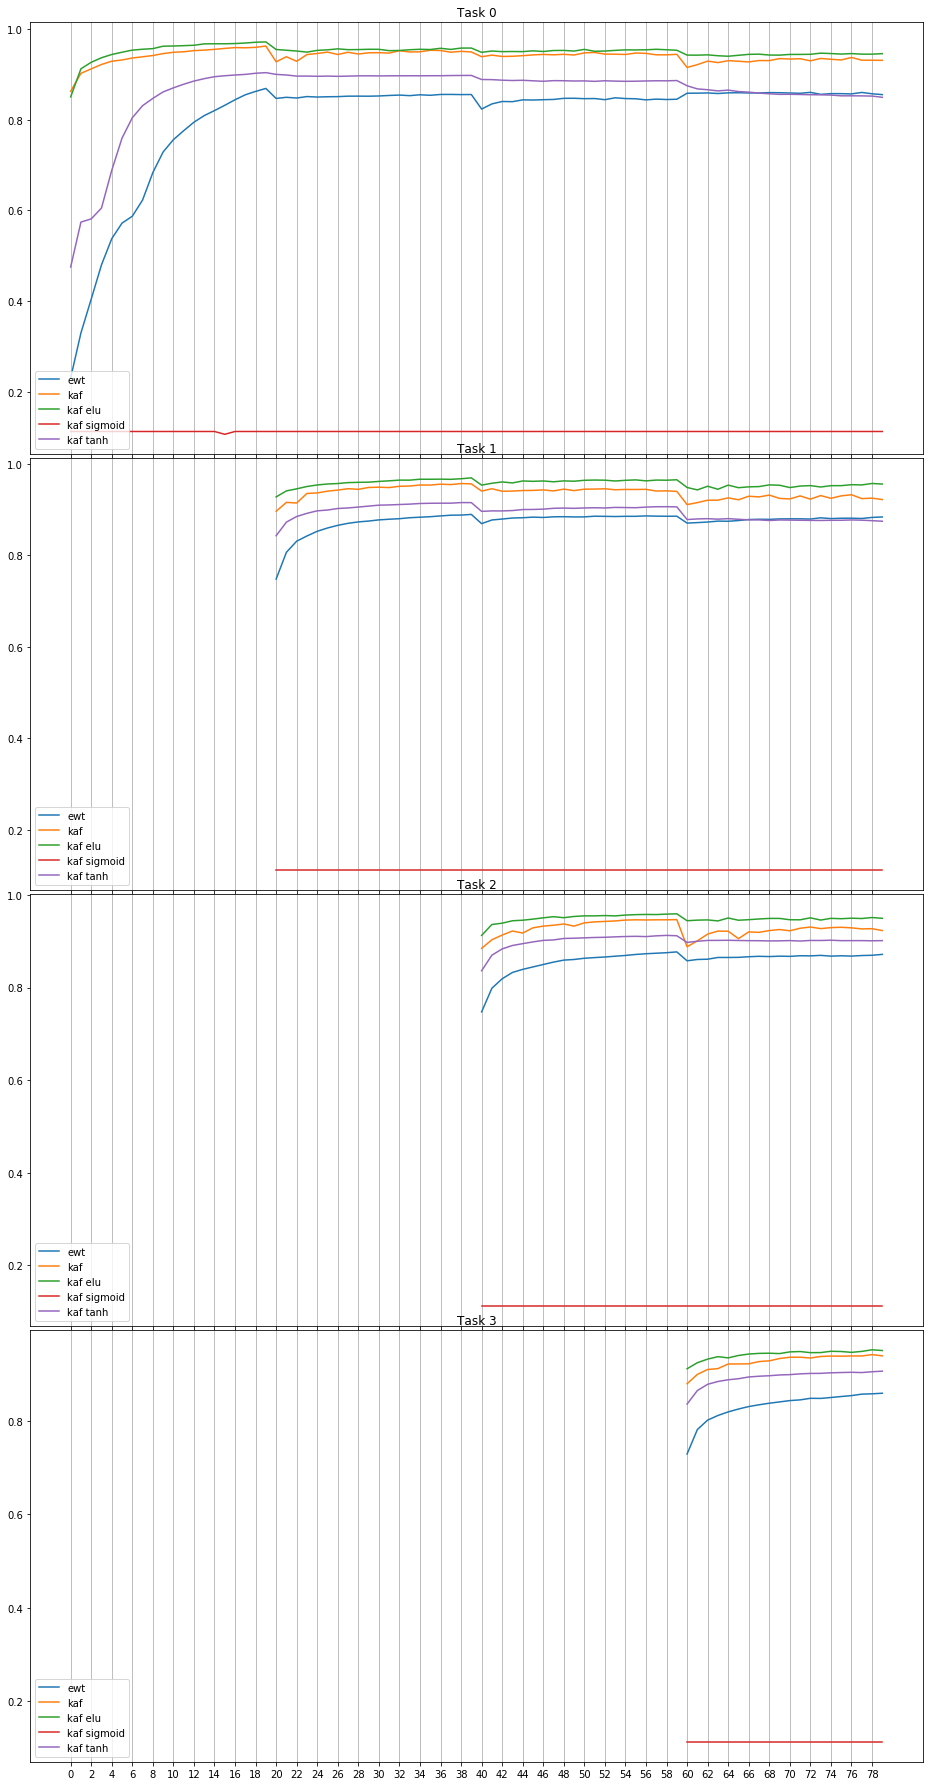

In [14]:
n_task = len(metrics_ewt['tasks'])
tot_epochs = 0

print('Online ewc', metrics_ewt['metrics'])
print('KAF', metrics_kaf['metrics'])
print('KAF tanh', metrics_kaf_tanh['metrics'])
print('KAF elu', metrics_kaf_elu['metrics'])
print('KAF sigmoid', metrics_kaf_sigmoid['metrics'])

for k, v in metrics_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))

fig = plt.figure(figsize=(16, 32))

ax = None
for i, task in enumerate(metrics_ewt['tasks'].keys()):
        
    ewt = metrics_ewt['tasks'][task]    
    kaf = metrics_kaf['tasks'][task]
    kaf_elu = metrics_kaf_elu['tasks'][task]
    kaf_sigmoid = metrics_kaf_sigmoid['tasks'][task]
    kaf_tanh = metrics_kaf_tanh['tasks'][task]
    

    x = range(tot_epochs-len(kaf['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, ewt['f1'], label='ewt')
    ax.plot(x, kaf['f1'], label='kaf')
    ax.plot(x, kaf_elu['f1'], label='kaf elu')
    ax.plot(x, kaf_sigmoid['f1'], label='kaf sigmoid')
    ax.plot(x, kaf_tanh['f1'], label='kaf tanh')
    
    
    ax.set_xticks(list(range(0, tot_epochs, 2)), minor=False)
    
    ax.set_title("Task {}".format(task))
    ax.legend(loc="lower left")
    ax.grid(True, axis='x')
    
fig.subplots_adjust(hspace=0.01)


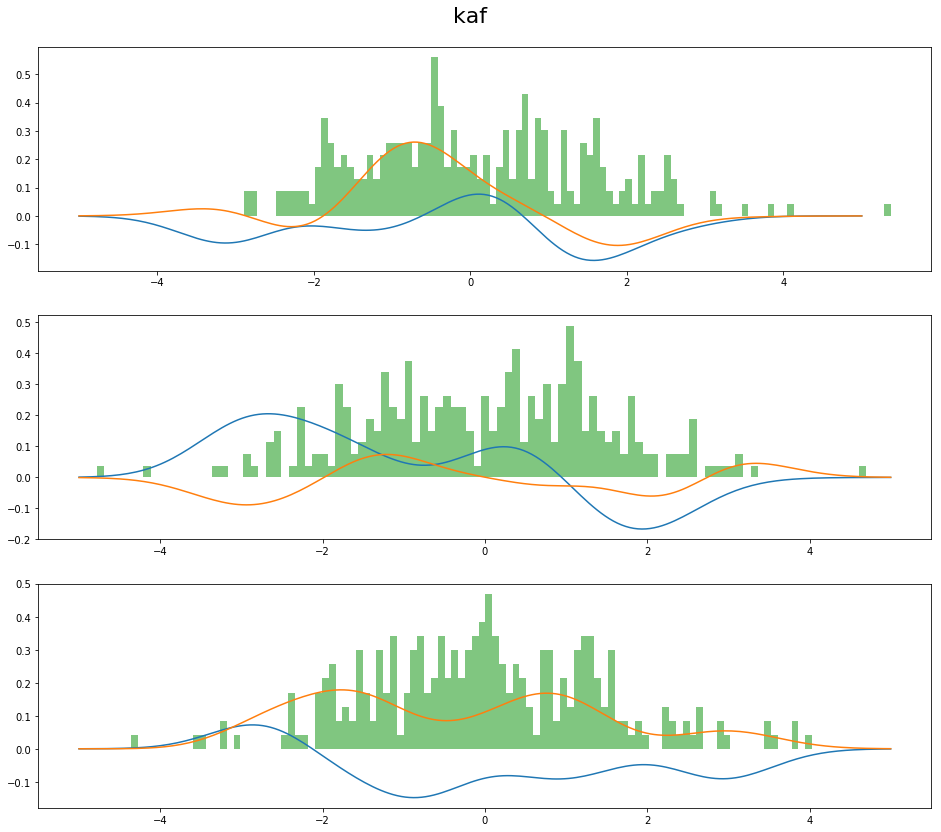

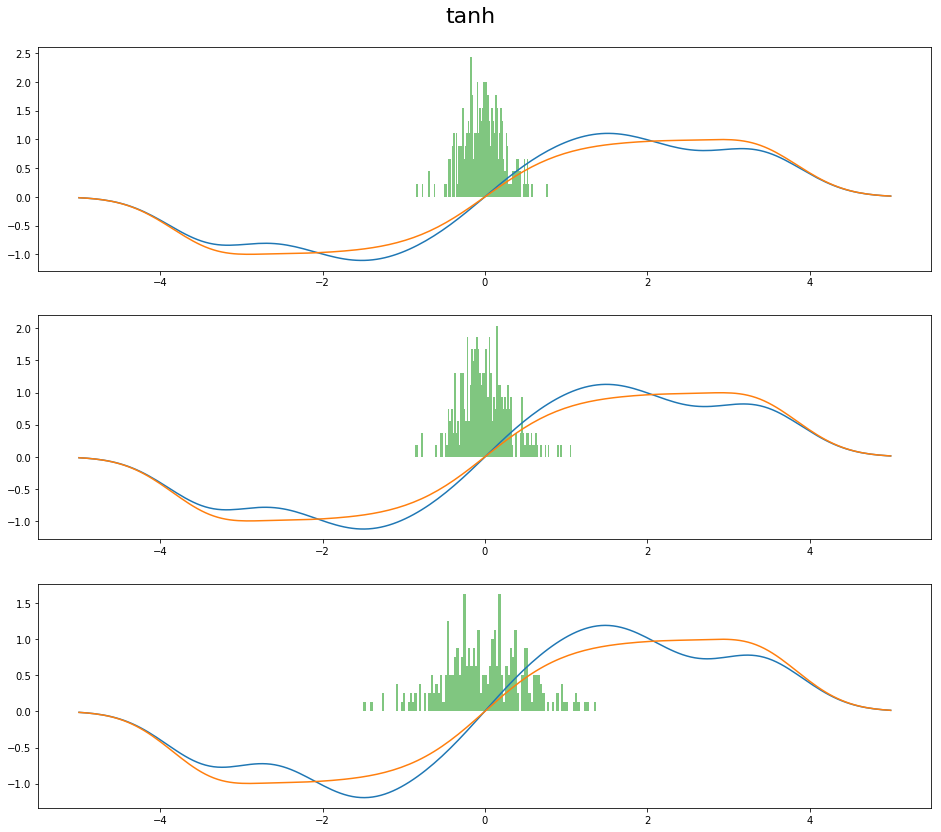

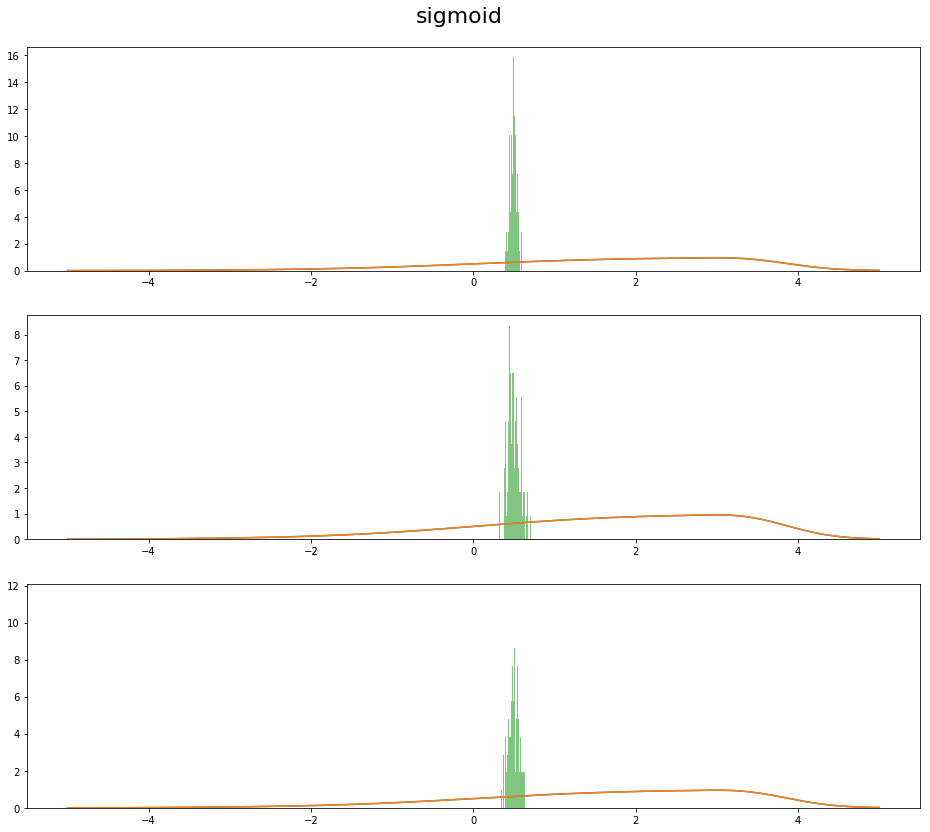

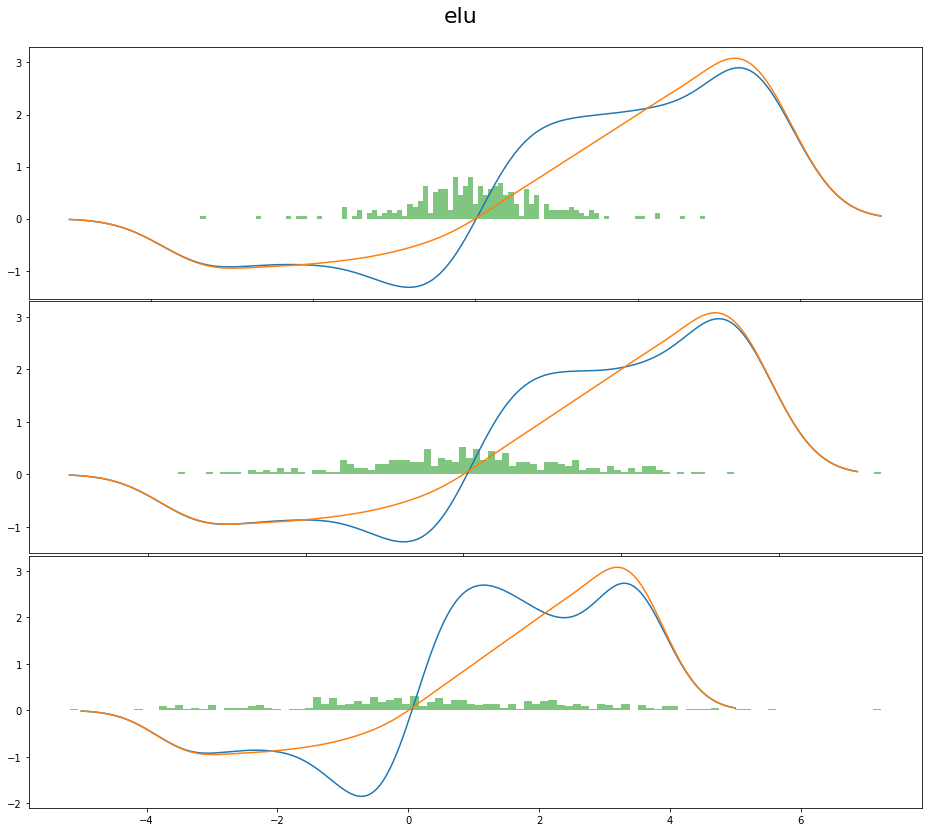

In [15]:
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)
    
x = list(range(20))
x = np.linspace(-5, 5, 100).astype(np.float32)
common_params = {'histtype': 'step'}

for trainer, old_model, t in [(trainer_kaf, old_kaf,  'kaf'), (trainer_kaf_tanh, old_kaf_tanh, 'tanh'), 
                   (trainer_kaf_sigmoid, old_kaf_sigmoid, 'sigmoid'), 
                                (trainer_kaf_elu, old_kaf_elu, 'elu')]:
    model = trainer.model
    fig, ax = plt.subplots(3, 1, sharex=False, figsize=(16, 14))
    fig.suptitle(t, size=22, y=0.92)
    
    for _, m in model.named_modules():
        m.register_forward_hook(hook)
        
    img = dataset[0][0]
    trainer.model(torch.Tensor(img).unsqueeze(0).cuda())
    
    hooked_params = dict(model.named_modules())
    
    for i in [1, 2, 3]:
        name = 'kaf'+str(i)

        c = []
        old = []
        
        for j in x:
            kaf = getattr(model, name)
            input = torch.Tensor([j]).unsqueeze(0).cuda()#.repeat(1, int(400*0.7), 1)
            res = kaf.forward(input).detach().cpu().numpy()[0]
            c.append(np.mean(res))
            
            res = getattr(old_model, name).cuda().forward(input).detach().cpu().numpy()[0]
            old.append(np.mean(res))

        spl = make_interp_spline(x, c, k=3)
        xnew = np.linspace(min(x), max(x), 200)
        ax[i-1].plot(xnew, spl(xnew))
        
        spl = make_interp_spline(x, old, k=3)
        ax[i-1].plot(xnew, spl(xnew))

        forward = hooked_params[name]._value_hook.detach().cpu().numpy()[0]
        ax[i-1].hist(x=forward, bins=100, histtype='stepfilled', density=True, alpha=0.6)
        #ax[i-1].set_xticks(x)


        
fig.subplots_adjust(hspace=0.01)
plt.show()
